In [1]:
from functools import partial
# import sys
# sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import KBio


In [2]:
# p = KBio.Polynomial(degree = 3, c=1)
p = KBio.Gaussian(sigma=5e-3)

In [3]:
np.random.seed(7)

We'll run our simulation with a time step (Euler method) of 0.01, 5% initial infection (this is quite high, but avoids stability issues **and** makes for way more awesome plots).

In [4]:
beta = 4e-3
gamma = 1e-3
T_final = 6e1
dt = 1e-2  # for Euler step
data = KBio.rectangular_grid([0], [6e1], [60 + 1])
sim = KBio.SIS_sim(dt=dt, T_final=T_final, beta=beta, gamma=gamma, I0 = 5, S0 = 95)
sim(data, forcing = lambda x: 1.8e-4*np.sin(0.01 + 0.4*x))

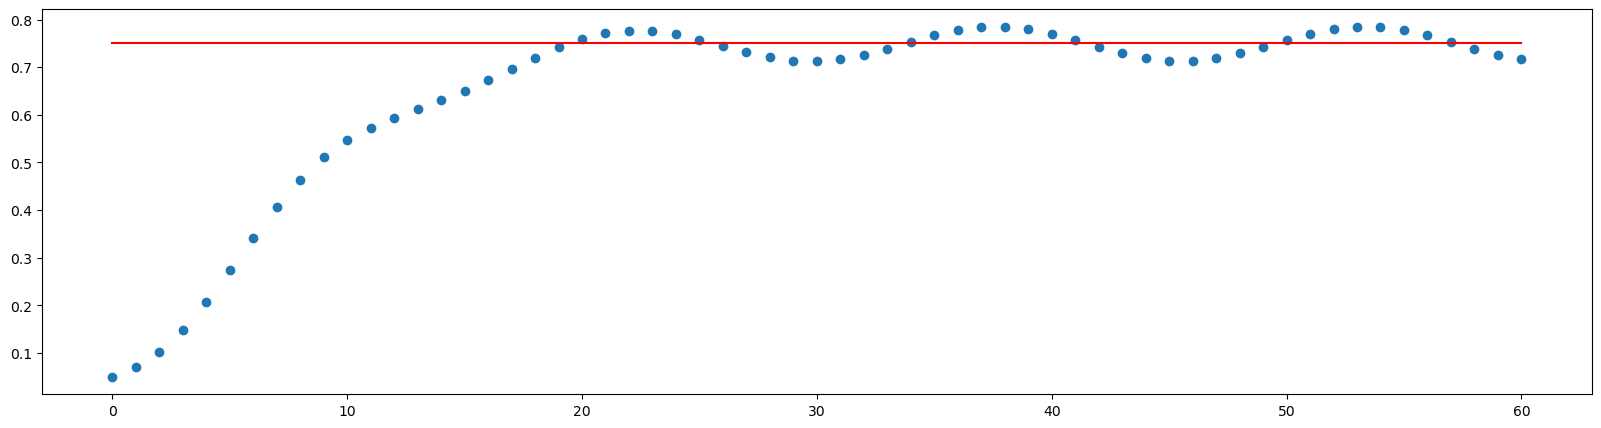

In [5]:
plt.figure(figsize=(20,5))
plt.plot(data.grid_tensors[0], data.grid_tensors_values, 'o')
# Put a vertical line at asymptotic steady state under no perturbation
steady_state = sim.asymptotic_steady_state() # 1 - 1/R0
# horizontal line from 0 to T_max at the asymptotic steady state
plt.plot([0, np.max(data.grid_tensors[0])], [steady_state, steady_state], 'r')

Now let's generate a small data set of 200 points, with 100 trajectories, and plot it. We'll sample the forcing functions as sinusoids with random frequencies and amplitudes, and constants. 

<!-- 80 trajectories will be with sinusoidal forcing, and 20 will be constant. -->

In [6]:
def oscillatory_forcing(A, omega, phi, t):
    return A*np.sin(omega + phi*t) * np.minimum(1, t/10)

def constant_forcing(A, t):
    return A * np.minimum(1, t/10)

In [7]:
n_samples_oscillatory = 4
# use log-uniform distribution to generate amplitudes
amplitudes = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory))

# use uniform distribution to generate frequencies
shifts = np.random.uniform(0, np.pi, n_samples_oscillatory)
print(shifts)
frequencies = np.random.uniform(1, 6, n_samples_oscillatory)
forcing_functions = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitudes, shifts, frequencies)]
grids_oscillatory = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_oscillatory)]
for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory, amplitudes, shifts, frequencies, forcing_functions):
    sim(grid, forcing = fn)

[3.07244467 1.69173467 1.57431637 0.22635531]


Our oscillatory forcing function is of the form
$$
f(t) = \min(1, t / 10) A \sin(\omega t + \phi)
$$

So by day 10, the forcing function will be at its full amplitude. This avoids issues where the forcing function overpowers the dynamics of the system and makes the trajectories non-physical. 

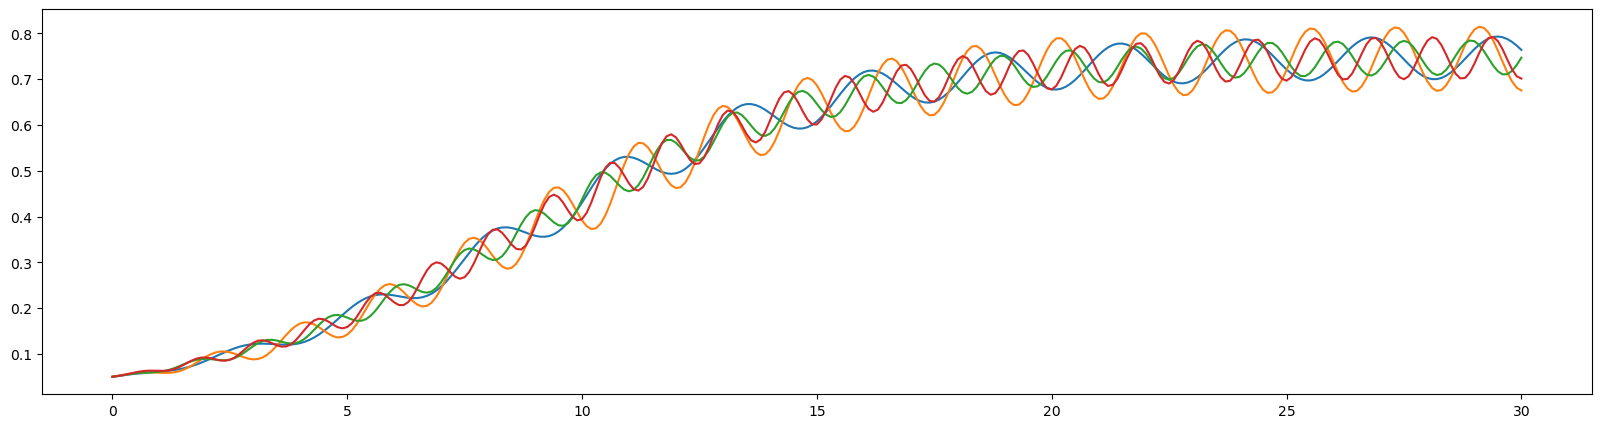

In [8]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [9]:
n_samples_constant = 2
grids_constant = [KBio.rectangular_grid([0], [30], [301]) for _ in range(n_samples_constant)]

constant_values = np.random.normal(0, 1e-4, n_samples_constant)
functions_constant = [partial(constant_forcing, constant_value) for constant_value in constant_values]
for grid, constant_value, fn in zip(grids_constant, constant_values, functions_constant):
    sim(grid, forcing = fn)

In [10]:
constant_values

array([-6.25428974e-05, -1.71548261e-05])

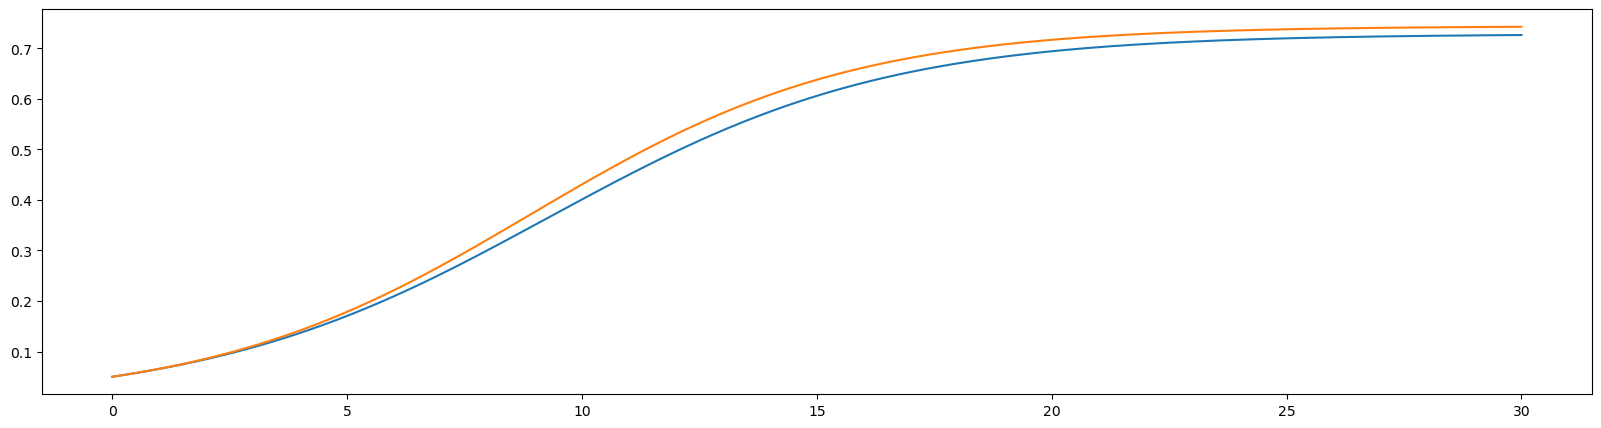

In [11]:
plt.figure(figsize=(20,5))
for grid in grids_constant:
    plt.plot(grid.grid_tensors[0], grid.grid_tensors_values)

In [12]:
grids_all = grids_oscillatory # + grids_constant


In [13]:
# Reformat the data into a format that can be used by the Kernel
smoothed_data = []
smoothed_derivatives = []
alphas_list = [[0], [1], [2]]
x_data = np.stack([grid.grid_tensors[0] for grid in grids_all])
# x_data += np.random.normal(0, 1e-2, x_data.shape)
# standardize x_data to mean 0 variance 1
x_mean = np.mean(x_data)
x_std = np.std(x_data)
x_data = (x_data - x_mean) / x_std
y_data = np.stack([grid.grid_tensors_values for grid in grids_all])
# y_data += np.random.normal(0, 1e-3, y_data.shape)
f_data = np.stack([grid.grid_tensors_forcing for grid in grids_all])

z, kdList, u_smoothed = KBio.kernel_smoothing(p, x_grid = x_data, u_data = y_data, f_data = f_data, alpha_list=alphas_list, nugget=1e-8)
# u_smoothed

Reshaping x_grid in smoother
(4, 301, 1)
n_grid_pts:  301


In [14]:
print(p)

Gaussian with sigma 0.005


In [15]:
1 / p.sigma

200.0

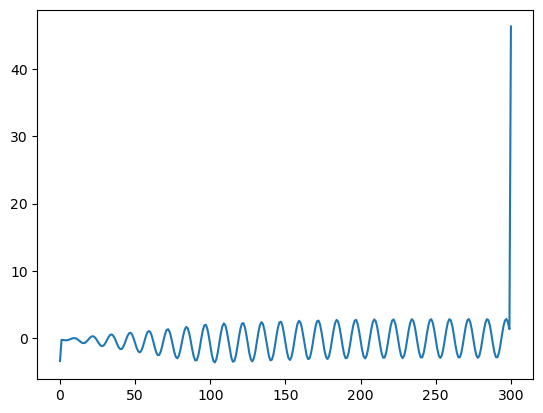

In [16]:
plt.plot(u_smoothed[1][:,3])

## Exploratory side-quest on the derivative matrices we just calculated.

Below are some plots used to verify that this method is working as intended.

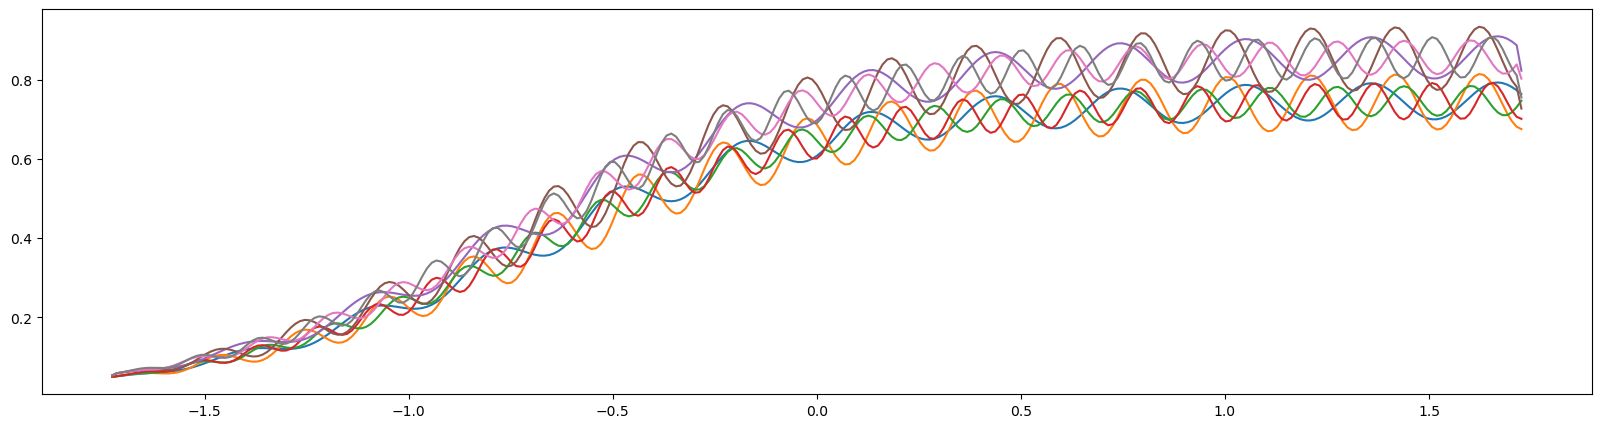

In [17]:
plt.figure(figsize=(20,5))
for grid in grids_oscillatory:
    plt.plot((grid.grid_tensors[0] - x_mean) / x_std, grid.grid_tensors_values, label='original')

plt.plot(x_data[0,:], u_smoothed[0], label='smoothed')
plt.show()
# plt.legend()

In [18]:
u_smoothed[0].shape

(301, 4)

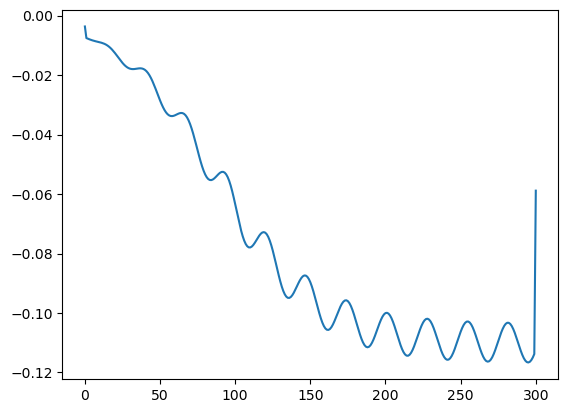

In [19]:
gap = grids_oscillatory[0].grid_tensors_values - u_smoothed[0][:,0]
plt.plot(gap)

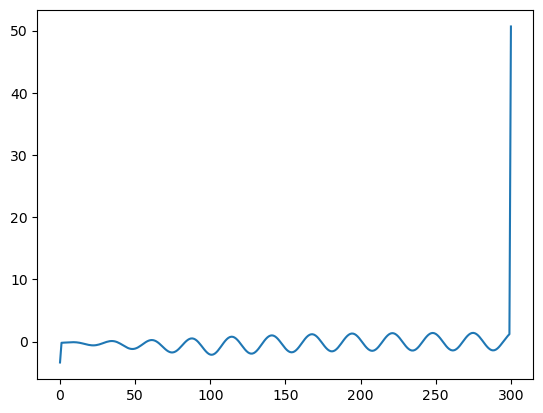

In [20]:
# plt.plot(u_smoothed[0][:,0])
plt.plot(u_smoothed[1][:,0])

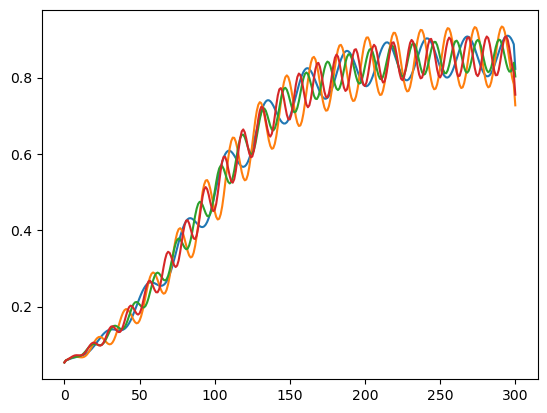

In [21]:
plt.plot(u_smoothed[0])
plt.show()

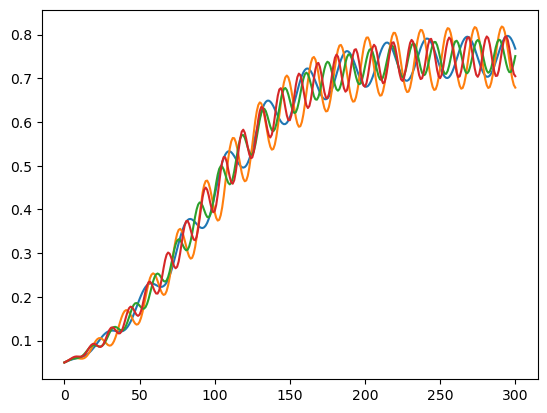

In [22]:
plt.plot(z)

In [23]:
kdList[1].shape

(301, 301)

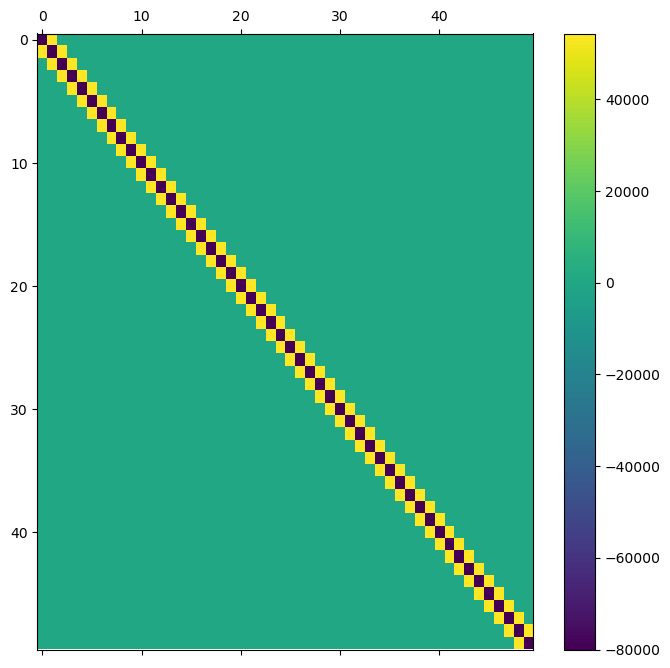

In [24]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
mappable = ax.matshow(kdList[2][0:50, 0:50])
ax.set_aspect('auto')
plt.colorbar(mappable)
plt.show()

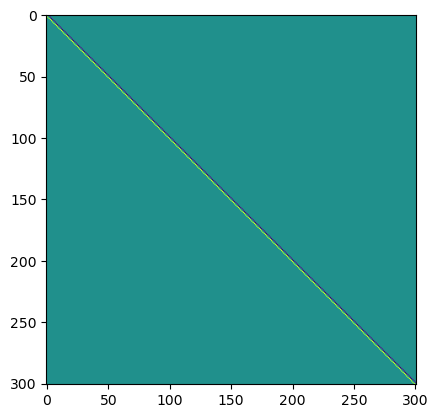

In [25]:
plt.imshow(kdList[1])

# Assemble derivative "features" at each grid point

In [26]:
feature_functions = []

def ident(index, x, u, u_deriv_list):
    """ Identity feature function for the $index$-th derivative of the function"""
    if np.abs(int(index) - index) > 1e-10:
        raise ValueError('Only the first derivative is available')
    if index == 0:
        return u
    else:
        return u_deriv_list[index]
# Get the first 2 derivatives and the function itself
for i in range(1,3):
    feature_functions.append(partial(ident, i))

# quadratic feature function
def quadratic(index, x, u, u_deriv_list):
    """ Quadratic feature function for the $index$-th derivative of the function

    The feature function is $u^2$ for the function itself and $2u u'$ for the first derivative.
    """

    if index == 0:
        return u**2
    elif index == 1:
        return 2*u*u_deriv_list[index]
    else:
        raise ValueError('Higher derivatives are not implemented')

feature_functions.append(partial(quadratic, 0))
# feature_functions.append(partial(quadratic, 1))

In [27]:
x_grid_list = grid.grid_list  # Get the grid of points as a list
F0 = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed[0], multi_derivatives=u_smoothed, function_list=feature_functions)
# Reshape the feature tensor into a feature matrix, combining the first two dimensions
# Only FLATTEN the first two dimensions together.abs


# Below is the same as the above, just slower since we need to do a copy.
# # Now do it by for loops
# F1 = np.zeros((F.shape[0] * F.shape[1], F.shape[2]))
# for i in range(F.shape[0]):
#     for j in range(F.shape[1]):
#         F1[i*F.shape[1] + j] = F[i,j]

# labels/regression targets
f_data_flat = f_data.reshape(-1, 1)

In [28]:
# normalize F0 feature-wise, so that each feature has mean 0 and variance 1
F0_mean = np.mean(F0, axis=0)
F0_std = np.std(F0, axis=0)
F0 = np.divide((F0 - F0_mean), F0_std, where = (F0_std != 0))

In [29]:
F0_mean

array([ 1.50000000e+01,  5.97415054e-01,  5.97415054e-01, -1.46380865e-01,
        1.49103009e+04, -1.46380865e-01,  1.49103009e+04,  4.37644683e-01])

In [30]:
F0_mean

array([ 1.50000000e+01,  5.97415054e-01,  5.97415054e-01, -1.46380865e-01,
        1.49103009e+04, -1.46380865e-01,  1.49103009e+04,  4.37644683e-01])

In [31]:
F0_std

array([8.68907360e+00, 2.84147736e-01, 2.84147736e-01, 3.16682305e+00,
       7.39816611e+03, 3.16682305e+00, 7.39816611e+03, 2.90395202e-01])

In [32]:
F0.std(axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1.])

We should use the F0 technique and just reshape, but in case we want to sanity check that it gives the natural ordering, we can do it manually.

In [33]:
q = KBio.Gaussian(sigma=2e-1)

In [34]:
predictor, weight_vector = KBio.learn_DE_form(kernel=q, s_features=F0, f_labels=f_data_flat, nugget=1e-1)

In [35]:
predictor

<function KBio.kernelRoutines.learn_DE_form.<locals>.predictor(new_features)>

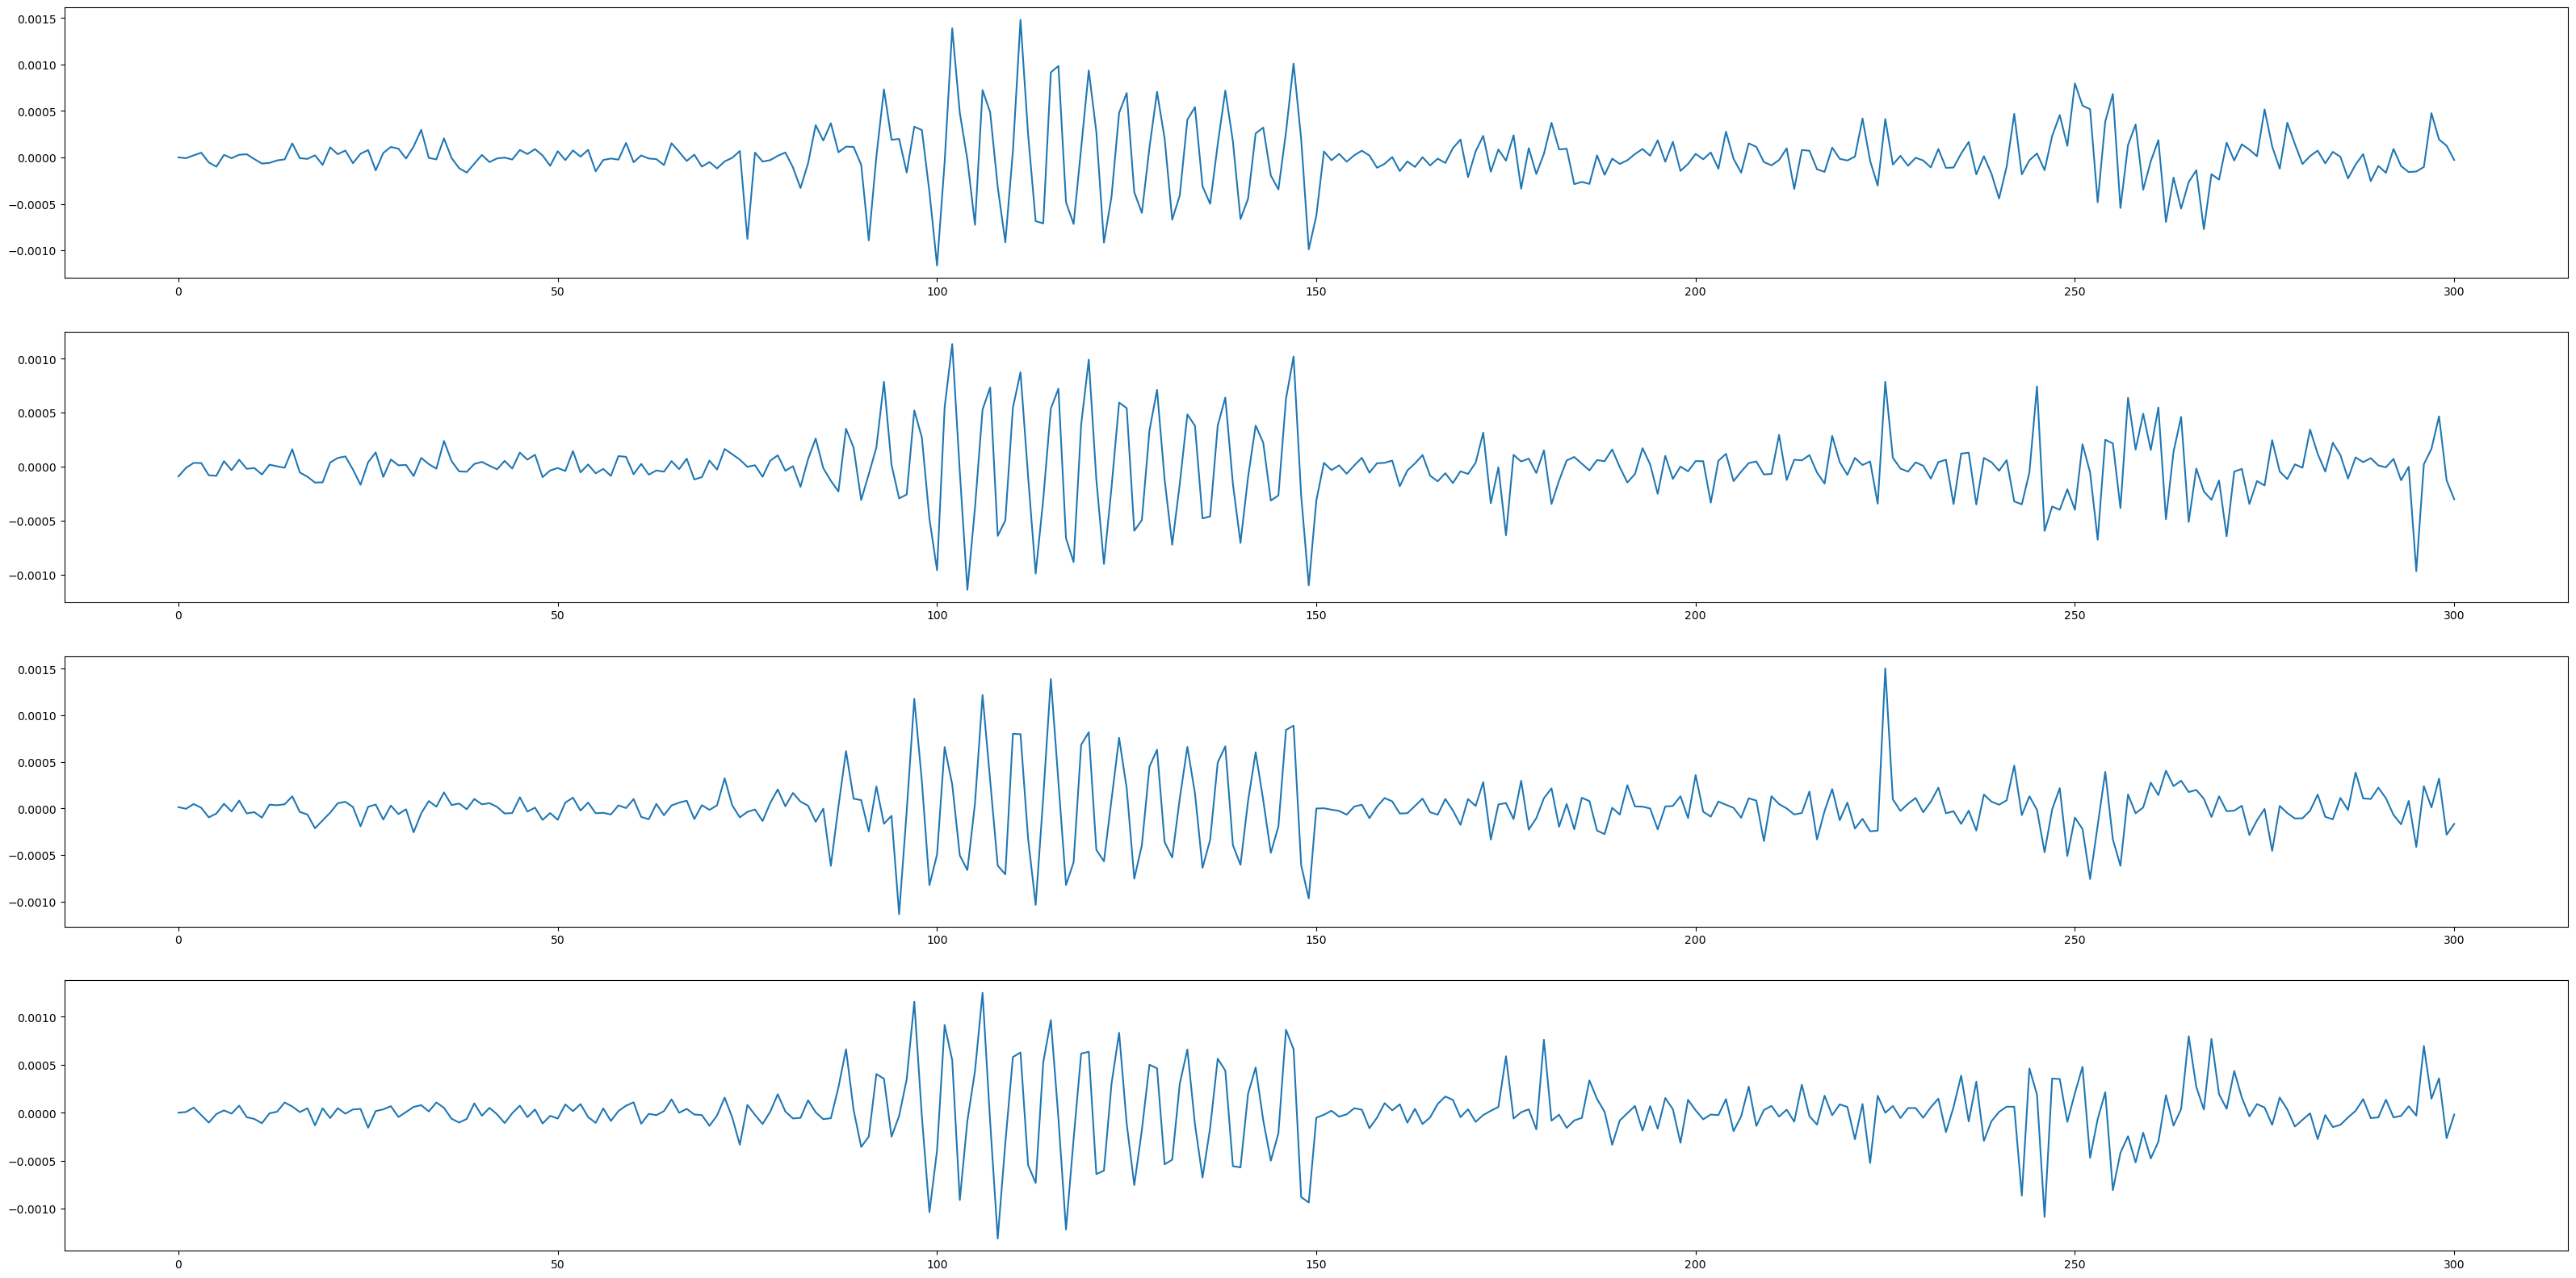

In [37]:
fig, ax = plt.subplots(4, 1, figsize=(40,20))
wv_matrix = weight_vector.reshape(301, weight_vector.shape[0] // 301)
for i in range(4):
    ax[i].plot(wv_matrix[:,i])

In [38]:
wv_matrix.shape

(301, 4)

In [39]:
weight_vector.shape

(1204, 1)

# Test out the technique on a set of new trajectories

In [40]:
# Repeat the above for a testing/validation set for demonstrations.

np.random.seed(1947)
n_samples_oscillatory_test = 6

amplitude_test = 10 ** (np.random.uniform(-3, -2.5, n_samples_oscillatory_test))
shift_test = np.random.uniform(0, np.pi, n_samples_oscillatory_test)
frequencies_test = np.random.uniform(1, 6, n_samples_oscillatory_test)

forcing_functions_test = [partial(oscillatory_forcing, amplitude, shift, frequency) for amplitude, shift, frequency in zip(amplitude_test, shift_test, frequencies_test)]
grids_oscillatory_test = [KBio.rectangular_grid([0], [60], [601]) for _ in range(n_samples_oscillatory_test)]

for grid, amplitude, shift, frequency, fn in zip(grids_oscillatory_test, amplitude_test, shift_test, frequencies_test, forcing_functions_test):
    sim(grid, forcing = fn)


In [41]:
# Smooth this new data in the same way as before
x_data_test = np.stack([grid.grid_tensors[0] for grid in grids_oscillatory_test])
x_data_test += np.random.normal(0, 1e-2, x_data_test.shape) # Add some noise to the x data
# Make sure we use the same scaling transform here as we did before.
x_data_test = (x_data_test - x_mean) / x_std
y_data_test = np.stack([grid.grid_tensors_values for grid in grids_oscillatory_test])

f_data_test = np.stack([grid.grid_tensors_forcing for grid in grids_oscillatory_test])

In [42]:
# Now smooth it
z_test, kdList_test, u_smoothed_test = KBio.kernel_smoothing(p, x_grid = x_data_test, u_data = y_data_test, f_data = f_data_test, alpha_list=alphas_list, nugget=1e-14)

Reshaping x_grid in smoother
(6, 601, 1)
n_grid_pts:  601


In [ ]:
u_smoothed_test[0].shape

(601, 6)

In [ ]:
F0_test = KBio.assemble_features(x_grid_list=x_grid_list, u_smoothed=u_smoothed_test[0], multi_derivatives=u_smoothed_test, function_list=feature_functions, flatten=False)
# standardize the test data
F0_test = np.divide((F0_test - F0_mean), F0_std, where = (F0_std != 0))

In [ ]:
F0_test.shape

(6, 601, 9)

In [ ]:
s_test = np.zeros((F0_test.shape[1], F0_test.shape[1]))
for i in range(F0_test.shape[1]):
    for j in range(F0_test.shape[1]):
        s_test[i,j] = q(F0_test[0,i,:], F0_test[0,j,:] )
# s_test = q(F0_test[0,:,:], F0_test[0,:,:])

In [ ]:
F0_test[0,1,:] - F0_test[0,2,:]

array([-0.0057639 , -0.00823886, -0.00823886, -0.02181747,  0.00824622,
       -0.02181747,  0.00824622, -0.00090988, -0.00163511])

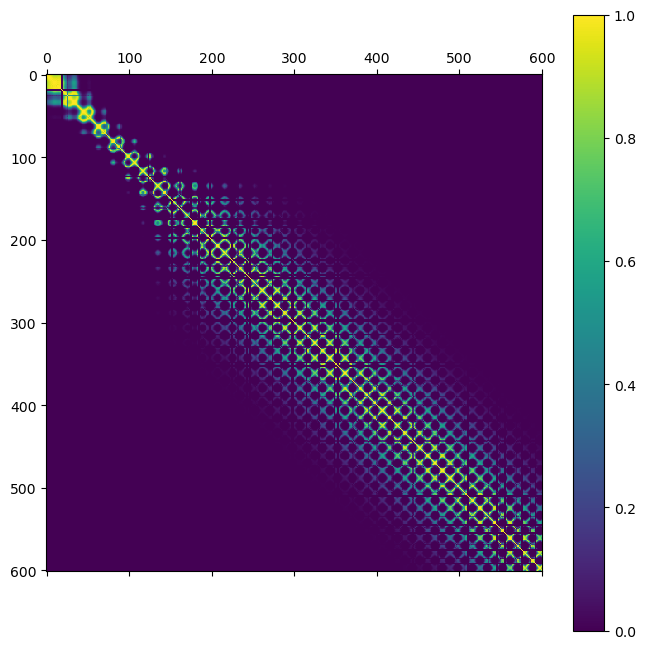

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
mappable = ax.matshow(s_test)
fig.colorbar(mappable)

In [ ]:
F0_test[0,1,:].shape

(9,)

In [ ]:
k_new, preds = predictor(F0_test[0,:,:])

(601, 24040) (24040, 1)


In [ ]:
k_new.max()

0.9999998077096295

/tmp/ipykernel_3604184/3383889502.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


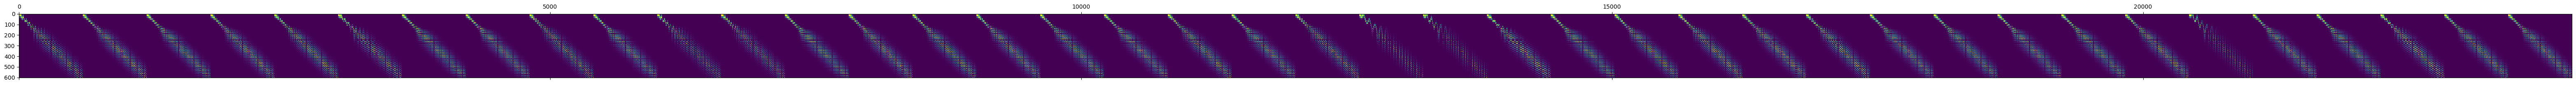

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(80, 10))
ax.matshow(k_new)
fig.show()

In [ ]:
preds_all = []
for i in range(F0_test.shape[0]):
    print(i)
    k_new, preds = predictor(F0_test[i,:,:])
    preds_all.append(preds)

0
(601, 24040) (24040, 1)
1
(601, 24040) (24040, 1)
2
(601, 24040) (24040, 1)
3
(601, 24040) (24040, 1)
4
(601, 24040) (24040, 1)
5
(601, 24040) (24040, 1)


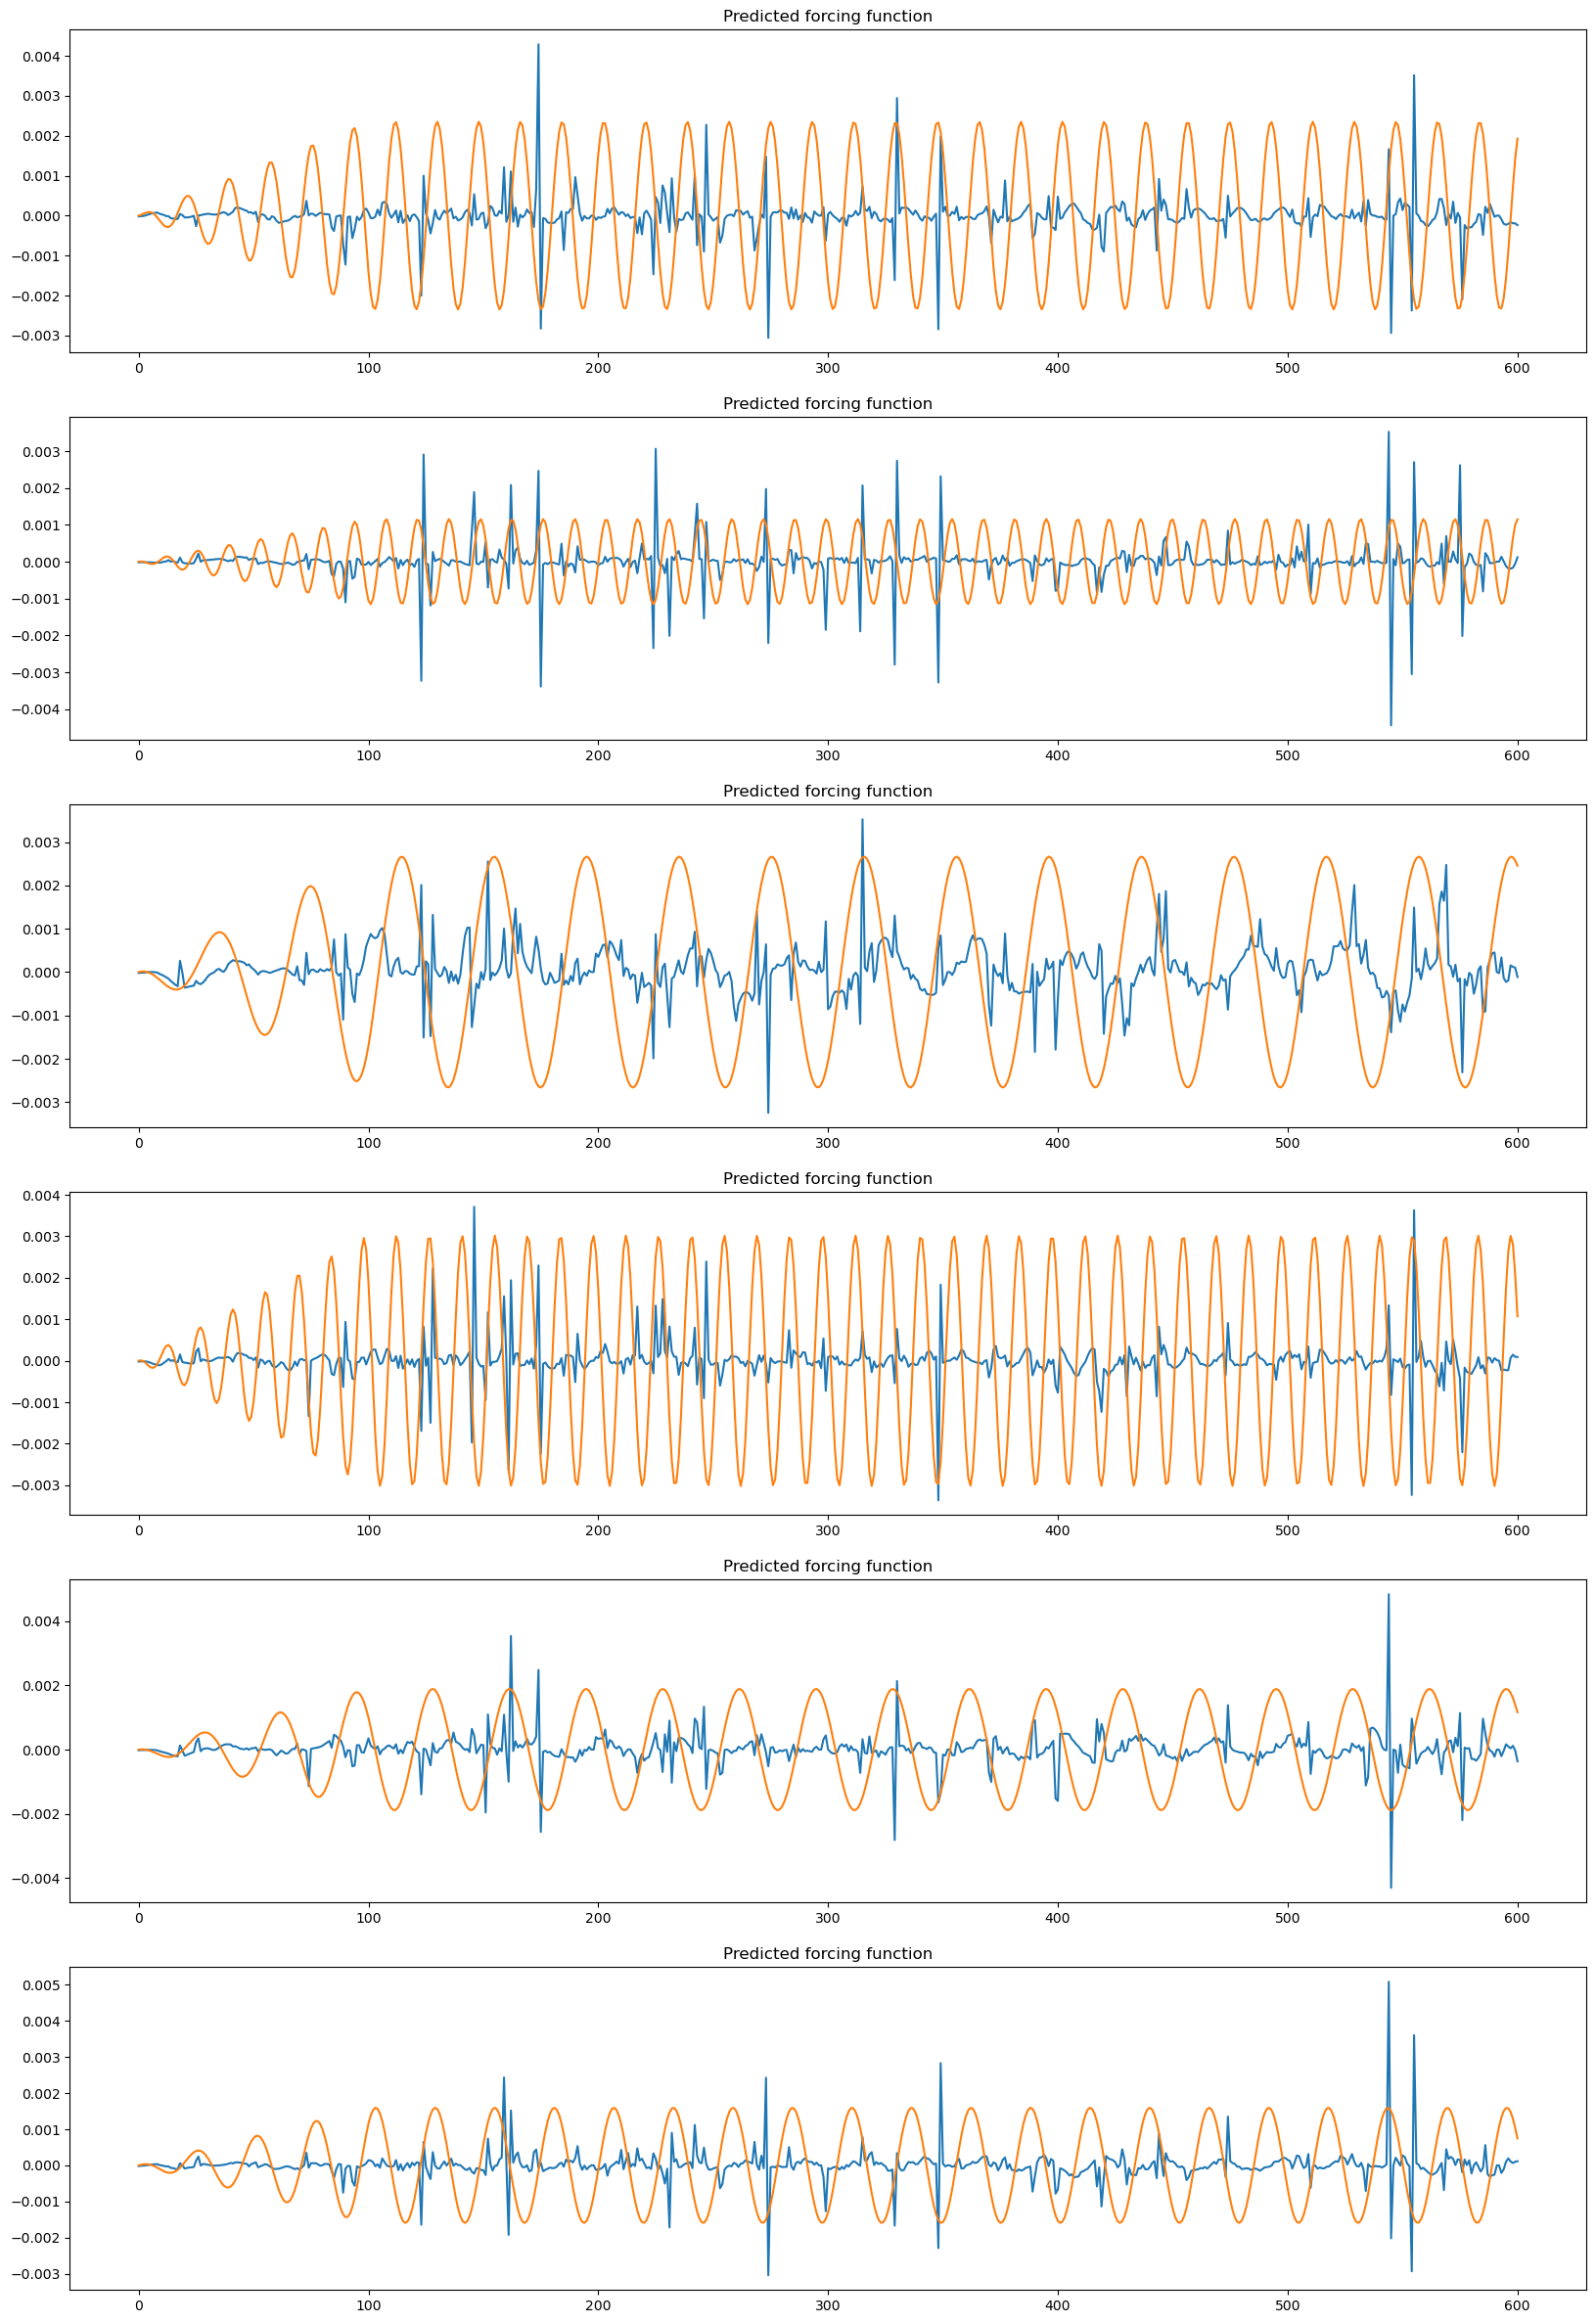

In [ ]:

fig, ax = plt.subplots(n_samples_oscillatory_test, 1, figsize=(20,5 * n_samples_oscillatory_test))
for i in range(n_samples_oscillatory_test):
    ax[i].plot(preds_all[i], label='Predicted')
    ax[i].set_title("Predicted forcing function")
    ax[i].plot(f_data_test[i], label='True')